In [16]:
from pyspecter.SPECTER import SPECTER
from pyshaper.Shaper import Shaper

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles, random_triangles, kT_N, center_sort_and_normalize
from rikabplotlib.plot_utils import newplot, plot_event, hist_with_errors, hist_with_outline, function_with_band


# Standard imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import tqdm

# Necessary GPU nonsense for SHAPER
import torch 
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


In [17]:
# CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 100 # Note that runtime is pad^2, memory is pad^4

dataset = "CMS"
n_samples = 2500# CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 100 # Note that runtime is pad^2, memory is pad^4

dataset_name = "CMS"
n_samples = 2500*10
batch_size = 1 # Number of pairs to process in parallel, can probably be increased.

if dataset_name == "CMS":

    # Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
    dataset, sim_weights, k_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta_cut, quality, pad = pad, n = 1000000, amount=1)
    weights = sim_weights * k_factors

    print("Loaded dataset with {} events".format(len(dataset)))
    print("Trimmig to {} events".format(n_samples)  )
    shuffle = np.random.permutation(len(dataset),)[:n_samples]
    dataset = dataset[shuffle]
    weights = weights[shuffle]



elif dataset_name == "Random Points":

    dataset, weights = random_triangles(n_samples, R)

# Split dataset into 2 halves
dataset1 = dataset[:n_samples//2]
dataset2 = dataset[n_samples//2:]
weights1 = weights[:n_samples//2]
weights2 = weights[n_samples//2:]


Max # of particles: 146
Loaded dataset with 46166 events
Trimmig to 25000 events


[[ 1.21149511e-01  1.73633607e-01 -5.19045330e-02]
 [ 8.97051563e-02 -1.97736218e-01  6.43196360e-02]
 [ 4.88904072e-02 -2.07507072e-01  5.51487470e-02]
 [ 4.64450885e-02  6.48808047e-02  4.54464204e-03]
 [ 4.08872262e-02  1.50339424e-01 -6.79347260e-02]
 [ 3.41159414e-02  1.76528715e-01 -3.31247790e-02]
 [ 3.00371350e-02  7.39021718e-02  4.67096830e-02]
 [ 2.50266167e-02 -1.37752767e-01  5.82733404e-03]
 [ 2.46251903e-02 -2.16520495e-01  1.03853010e-02]
 [ 2.36154026e-02  2.22739092e-01 -5.20617700e-02]
 [ 2.33896739e-02  1.70107413e-01 -3.95588620e-02]
 [ 2.16365420e-02  1.29060655e-01  1.88308020e-02]
 [ 1.92740856e-02  2.08695123e-01 -5.25200110e-02]
 [ 1.92328376e-02  9.66770293e-02 -3.40288620e-02]
 [ 1.90356511e-02 -3.42246979e-01  5.28251190e-02]
 [ 1.88710232e-02  1.84156397e-01 -5.77621200e-02]
 [ 1.85344492e-02  5.16351710e-02  5.82183860e-02]
 [ 1.83843761e-02 -1.48690621e-01  5.02486490e-02]
 [ 1.81329710e-02 -7.83993214e-02  1.27868201e-01]
 [ 1.75526087e-02  1.40765743e-

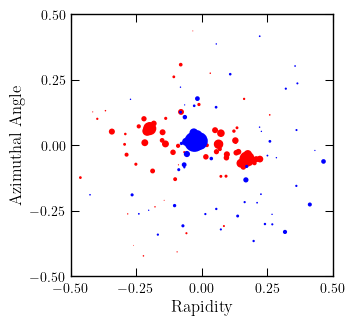

In [18]:
# Plots
fig, ax = newplot("column")

# Plot the first event
plot_event(ax, dataset1[0],R, color = "red")
print(dataset1[0])
plot_event(ax, dataset2[0],R, color = "blue")


In [19]:

# Make subfolder called shaper_vs_specter in the same directory as this script
dir = "/home/rikab/Documents/Research/SPECTER/Studies/shaper_vs_specter"
os.makedirs(dir, exist_ok = True)

# Set up and compile SPECTER
specter = SPECTER(compile = True)

# Function to compute EMDs as a function of N

def compute_SPECTER_SHAPER_n_jets(N, dataset1, dataset2, R):

    specter_filename = os.path.join(dir, "specter_emd_{}.npy".format(N))
    shaper_filename = os.path.join(dir, "shaper_emd_{}.npy".format(N))

    dataset1_N = center_sort_and_normalize(kT_N(dataset1, N, R = R))
    dataset2_N = center_sort_and_normalize(kT_N(dataset2, N, R = R))

    start = time.time()
    specter_emds = specter.spectralEMD(dataset1_N, dataset2_N)
    end = time.time()

    np.save(specter_filename, specter_emds)
    print("SPECTER took {} seconds".format(end - start))
    
    

    # Set up and compile SHAPER
    shaper = Shaper({}, device)
    shaper.to(device)

    start = time.time()

    # Note
    shaper_emds = shaper.pairwise_emds2(dataset1_N, dataset2_N, R = R, beta = 2, epsilon = 0.001)
    # shaper_emds = shaper.pairwise_emds_isometry(dataset1, dataset2, R = R, beta = 2, lr = 0.01, epsilon = 0.001)
    end = time.time()

    np.save(shaper_filename, shaper_emds)
    print("SHAPER took {} seconds".format(end - start))


Ns = [1, 2, 3, 4, 5, 10, 25, 50, 75, 100]
for N in tqdm.tqdm(Ns):
    compute_SPECTER_SHAPER_n_jets(N, dataset1, dataset2, R)

Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  2.2904603481292725  seconds.
Compiling spectral representation functions ...
Compiling observables...
Observables compiled! Time taken:  21.940057277679443  seconds.
Compilation complete! Time taken:  21.94006586074829  seconds.


  0%|          | 0/10 [00:00<?, ?it/s]

SPECTER took 0.26623010635375977 seconds


 10%|█         | 1/10 [00:11<01:41, 11.25s/it]

SHAPER took 3.926328420639038 seconds
SPECTER took 0.40618896484375 seconds


 20%|██        | 2/10 [00:20<01:21, 10.20s/it]

SHAPER took 2.0128426551818848 seconds
SPECTER took 0.5026004314422607 seconds


 30%|███       | 3/10 [00:29<01:07,  9.59s/it]

SHAPER took 1.33504319190979 seconds
SPECTER took 0.5446650981903076 seconds


 40%|████      | 4/10 [00:38<00:56,  9.41s/it]

SHAPER took 1.3626773357391357 seconds
SPECTER took 1.116731882095337 seconds


 50%|█████     | 5/10 [00:48<00:47,  9.47s/it]

SHAPER took 1.3049342632293701 seconds
SPECTER took 1.1127617359161377 seconds


 60%|██████    | 6/10 [00:58<00:38,  9.59s/it]

SHAPER took 1.5608835220336914 seconds
SPECTER took 2.8343892097473145 seconds


 70%|███████   | 7/10 [01:13<00:34, 11.44s/it]

SHAPER took 4.918847560882568 seconds
SPECTER took 7.83151650428772 seconds


 80%|████████  | 8/10 [01:54<00:41, 20.84s/it]

SHAPER took 25.298152446746826 seconds
SPECTER took 15.260355949401855 seconds


 90%|█████████ | 9/10 [03:09<00:37, 37.81s/it]

SHAPER took 51.82593607902527 seconds
SPECTER took 25.240189790725708 seconds


100%|██████████| 10/10 [05:05<00:00, 30.55s/it]

SHAPER took 82.4208173751831 seconds


# Plots

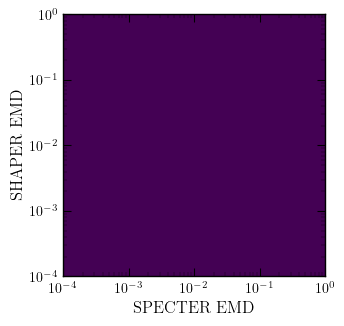

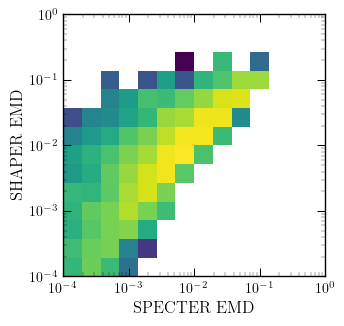

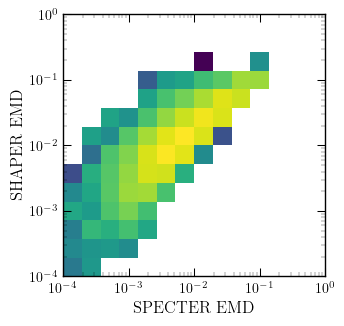

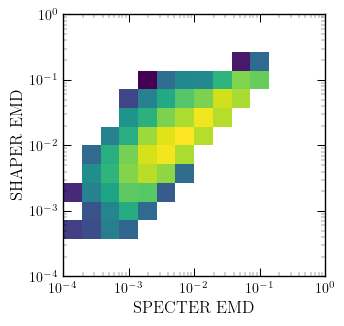

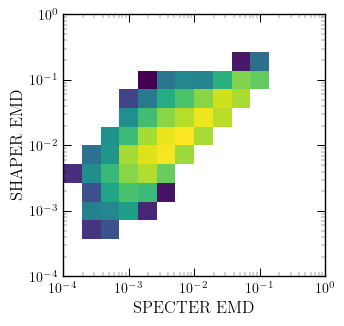

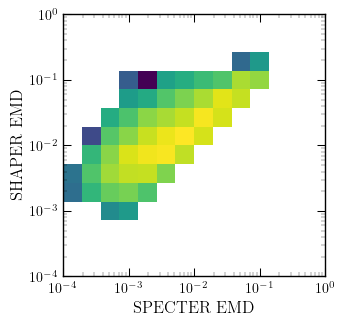

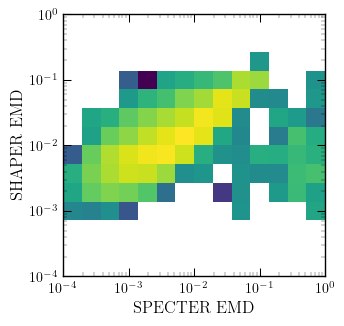

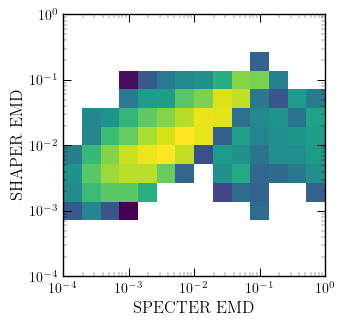

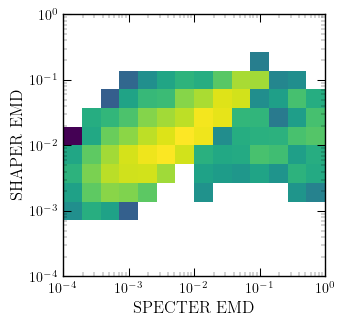

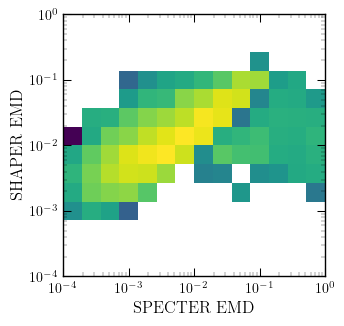

In [20]:


def plot_2d_hists(N, bins = 15):

    # Load the EMDs
    specter_filename = os.path.join(dir, "specter_emd_{}.npy".format(N))
    shaper_filename = os.path.join(dir, "shaper_emd_{}.npy".format(N))

    specter_emds = np.load(specter_filename)
    shaper_emds = np.load(shaper_filename)

    fig, ax = newplot("column")
    ax.set_aspect("equal")
    xbins = np.logspace(-4, 0, bins)
    ybins = np.logspace(-4, 0, bins)

    plt.hist2d(specter_emds, shaper_emds, bins = [xbins, ybins], cmap = "viridis", norm = matplotlib.colors.LogNorm(), weights=weights1*weights2)


    plt.xlabel("SPECTER EMD")
    plt.ylabel("SHAPER EMD")

    plt.xscale("log")
    plt.yscale("log")
    # plt.colorbar()


    plt.savefig(os.path.join("Plots/hist2d_{}.png".format(N)))


for N in Ns:
    plot_2d_hists(N, bins = 15)

In [21]:
import matplotlib

# plt.scatter(specter_emds, shaper_emds)
# plt.scatter(specter_emds, shaper_emds_no_isometry)

# log 2d histogram
newplot(width=9)

log = False
xbins = np.logspace(-4, 0, 25)
ybins = np.logspace(-4, 0, 25)
if log:
    plt.hist2d(specter_emds, shaper_emds, norm = matplotlib.colors.LogNorm(), bins = [xbins, ybins], density=False, weights=weights1*weights2)
else:
    plt.hist2d(specter_emds, shaper_emds, bins = [xbins, ybins], density=False, weights=weights1*weights2)
# diagonal line
x = np.linspace(0, 1, 1000)
plt.plot(x, x, color = "black")

plt.xlabel("SPECTER EMD")
plt.ylabel(r"2 SHAPER EMD$^{\beta = 2}$ / (Isometries)")
plt.xscale("log")
plt.yscale("log")
cbabr = plt.colorbar()
cbabr.set_label("Events")



ValueError: Invalid scale argument. Must be 'full' or 'column'.